# MNIST data valuation notebook with CLIP embeddings

---

This notebook compares two methods of calculating the "diversity" measure 
1. Difference-based diversity
2. Volume-based diversity

The basic algorithm of our data valuation method for a buyer's and seller's dataset
0. Embed the data in representation space with a pretrained model (optional)
1. Compute the buyer's components and values (eigendecomposition of the covariance matrix i.e. PCA)
2. Project the seller's data onto the buyer's components
3. Calculate "diversity" and "relevance" based off the buyer's and seller's magnitude's of theier eigenvalues
    * relevance is the $\prod_{i\in \text{C}}\min\left(\|\lambda^\text{buyer}_i\|, \|\hat{\lambda}^\text{seller}_i\|\right)$
    * diversity can be calculated in two ways
        1. the difference $\prod_{i\in \text{C}}\big|\|\lambda^\text{buyer}_i\| - \|\hat{\lambda}^\text{seller}_i\|\big|$
        2. the volume $\sqrt{\det(X_\text{seller}^T X_\text{seller})}$


Various comparisons between difference- and volume-diversity are made on the MNIST dataset in this notebook

## Module imports

In [7]:
from importlib import reload
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import math
import collections
from pathlib import Path
import numpy as np
import torch
from torchvision.transforms import Compose, ToPILImage
from torchvision.datasets import EMNIST, MNIST, SVHN, FashionMNIST, CIFAR10
from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights, resnet50, ResNet50_Weights
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('bmh')
from matplotlib import rcParams; rcParams['font.family'] = 'serif'
import clip
from tqdm.notebook import tqdm

# local imports
from data import subset, simple_DS
import valuation 
reload(valuation)
from valuation import get_volume, div_rel_func, get_value
import utils

## Make buyer and seller datasets

In [8]:
root = Path('../data/') # path to data directory
download = True # dowload data if dataset does not exist in data directory

# ds = SVHN(root=root, download=download) 
mnist_buyer = MNIST(root=root, train=False, download=download)
mnist_seller = MNIST(root=root, train=True, download=download)
fashion_seller = FashionMNIST(root=root, train=False, download=download)
cifar_seller = CIFAR10(root=root, train=False, download=download)
emnist_seller = EMNIST(root=root, split='byclass', train=False, download=download)

Files already downloaded and verified


### load pretrained model to embed data

In [9]:
assert torch.cuda.is_available()

In [10]:
use_clip_model = True

if use_clip_model:
    model, preprocess = clip.load("ViT-B/16", device='cuda')
else:
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
    # model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
    # model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()

model.eval();

In [11]:
make_loader = lambda x, batch_size=16: torch.utils.data.DataLoader(
    simple_DS(x, transforms=Compose([ToPILImage(), preprocess])), 
    batch_size=batch_size,
)
data_dict = dict(
    mnist_buyer=mnist_buyer.data, 
    mnist_seller=mnist_seller.data, 
    fashion_seller=fashion_seller.data, 
    cifar_seller=cifar_seller.data, 
    emnist_seller=emnist_seller.data.moveaxis(1, -1),
)
num_samples = 10000
features_dict = {
    k: torch.cat([model.encode_image(x.cuda()).detach().cpu() for x in tqdm(make_loader(v[:None if k == 'mnist_seller' else num_samples]))])
    for k, v in data_dict.items()
}

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

In [15]:
num_buyer = 100
num_seller = 5000

buyer_data = features_dict['mnist_buyer'][subset(mnist_buyer, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))][:num_buyer]
seller_1_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))][:num_seller]
seller_2_data = features_dict['mnist_seller'][subset(mnist_seller, ('1 - one', '2 - two', '3 - three', '4 - four', '5 - five'))][:num_seller]
seller_3_data = features_dict['mnist_seller'][subset(mnist_seller, ('2 - two', '3 - three', '4 - four', '5 - five', '6 - six'))][:num_seller]
seller_4_data = features_dict['mnist_seller'][subset(mnist_seller, ('3 - three', '4 - four', '5 - five', '6 - six', '7 - seven'))][:num_seller]
seller_5_data = features_dict['mnist_seller'][subset(mnist_seller, ('4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight'))][:num_seller]
seller_6_data = features_dict['mnist_seller'][subset(mnist_seller, ('5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))][:num_seller]
seller_7_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', ))][:num_seller]
seller_8_data = features_dict['mnist_seller'][subset(mnist_seller, ('5 - five', ))][:num_seller]
seller_9_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '5 - five'))][:num_seller]
seller_10_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '5 - five', '6 - six'))][:num_seller]
seller_11_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '5 - five', '6 - six', '7 - seven'))][:num_seller]
seller_12_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '5 - five', '6 - six', '7 - seven', '8 - eight'))][:num_seller]
seller_13_data = features_dict['mnist_seller'][subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))][:num_seller]

emnist_data = features_dict['emnist_seller'][subset(emnist_seller, ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'))[:num_samples]][:num_seller]
fashion_data = features_dict['fashion_seller'][:num_seller]
# svhn_data = features_dict['svhn'][:num_seller]
cifar_data = features_dict['cifar_seller'][:num_seller]

In [51]:
print(seller_1_data.shape)
print(seller_7_data.shape)
print(seller_13_data.shape)

torch.Size([5000, 512])
torch.Size([5000, 512])
torch.Size([5000, 512])


In [17]:
# copy data to measure robustness to duplication
n = seller_1_data.shape[0]
dup_1_data = seller_1_data[:int(n // 2)].repeat(2, 1) # 50% original
dup_2_data = seller_1_data[:int(n // 4)].repeat(4, 1) # 25% original
dup_3_data = seller_1_data[:int(n // 10)].repeat(10, 1) # 10% original
dup_4_data = seller_1_data[:int(n // 20)].repeat(20, 1) # 5% original
dup_5_data = seller_1_data[:int(n // 50)].repeat(50, 1) # 2% original

In [19]:
# mixture of MNIST and FashionMNIST datasets
mix_1_data = torch.cat([seller_1_data[:int(num_seller * 0.9)], fashion_data[:int(num_seller * 0.1)]])
mix_2_data = torch.cat([seller_1_data[:int(num_seller * 0.8)], fashion_data[:int(num_seller * 0.2)]])
mix_3_data = torch.cat([seller_1_data[:int(num_seller * 0.7)], fashion_data[:int(num_seller * 0.3)]])
mix_4_data = torch.cat([seller_1_data[:int(num_seller * 0.6)], fashion_data[:int(num_seller * 0.4)]])
mix_5_data = torch.cat([seller_1_data[:int(num_seller * 0.5)], fashion_data[:int(num_seller * 0.5)]])
mix_6_data = torch.cat([seller_1_data[:int(num_seller * 0.4)], fashion_data[:int(num_seller * 0.6)]])
mix_7_data = torch.cat([seller_1_data[:int(num_seller * 0.3)], fashion_data[:int(num_seller * 0.7)]])
mix_8_data = torch.cat([seller_1_data[:int(num_seller * 0.2)], fashion_data[:int(num_seller * 0.8)]])
mix_9_data = torch.cat([seller_1_data[:int(num_seller * 0.1)], fashion_data[:int(num_seller * 0.9)]])


## Data valuation with diversity and relevance measures

In [20]:
# number of PCA components to use
# n_components = 2
# n_components = 5
n_components = 10
# n_components = 15
# n_components = 20
# n_components = 50

# whether to use pretrained image features or raw data
# use_features = True 
# use_features = False

In [21]:
X_b = buyer_data
# X_b -= X_b.mean(0) 

X_s = seller_1_data
# X_s -= X_s.mean(0) 


buyer_cov = np.cov(X_b, rowvar=False)

# eigendecomposition of buyer's covariance matrix
buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)

# sort by decreasing eigenvalues
sorted_indices = np.argsort(buyer_eig_val)[::-1]
buyer_values = buyer_eig_val[sorted_indices].real
buyer_components = buyer_eig_vec[:, sorted_indices].real

print(f'first {n_components} components using numpy:', buyer_values[:n_components])

# project seller covariance onto buyer's components
np.linalg.norm(np.cov(X_s, rowvar=False) @ buyer_components[:, :n_components], axis=0)

first 10 components using numpy: [1.20405084 0.92792314 0.51527012 0.48712759 0.26029126 0.23222936
 0.17949771 0.15507689 0.122504   0.10921044]


array([0.90962396, 0.75182777, 0.37658867, 0.39643927, 0.26087934,
       0.19824651, 0.13057721, 0.14068104, 0.09203558, 0.07330611])

**We can also use sklearn's implmentation of PCA to get the same results**

In [22]:
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
pca.fit(X_b)

buyer_values = pca.explained_variance_
buyer_components = pca.components_

# PCA stores mean of previously fitted buyer's data; clear it since we already zero mean the seller data
pca.mean_ = None

print(f'first {n_components} components using sklearn:', buyer_values)
np.linalg.norm(pca.transform(np.cov(X_s, rowvar=False)), axis=0)
# pca.transform(X_b)

first 10 components using sklearn: [1.20405084 0.92792314 0.51527011 0.48712759 0.26029122 0.23222925
 0.17949607 0.15507138 0.12247439 0.10916398]


array([0.90962397, 0.75182776, 0.37659018, 0.39644011, 0.26088147,
       0.19824869, 0.13057323, 0.14062356, 0.09129005, 0.07314925])

### Compute volume-based diversity measure on projected data

In [42]:
threshold = 0.1
n_components = 10
omega = 0.1
norm_volume=True
kwargs= dict(threshold =threshold, n_components =n_components, omega = omega, norm_volume=norm_volume)

In [44]:
buyer_values = get_value(buyer_data, buyer_data, **kwargs)
seller_1_values = get_value(buyer_data, seller_1_data, **kwargs)
seller_2_values = get_value(buyer_data, seller_2_data, **kwargs)
seller_3_values = get_value(buyer_data, seller_3_data, **kwargs)
seller_4_values = get_value(buyer_data, seller_4_data, **kwargs)
seller_5_values = get_value(buyer_data, seller_5_data, **kwargs)
seller_6_values = get_value(buyer_data, seller_6_data, **kwargs)
seller_7_values = get_value(buyer_data, seller_7_data, **kwargs)
seller_8_values = get_value(buyer_data, seller_8_data, **kwargs)
seller_9_values = get_value(buyer_data, seller_9_data, **kwargs)
seller_10_values = get_value(buyer_data, seller_10_data, **kwargs)
seller_11_values = get_value(buyer_data, seller_11_data, **kwargs)
seller_12_values = get_value(buyer_data, seller_12_data, **kwargs)
seller_13_values = get_value(buyer_data, seller_13_data, **kwargs)
dup_1_values = get_value(buyer_data, dup_1_data, **kwargs)
dup_2_values = get_value(buyer_data, dup_2_data, **kwargs)
dup_3_values = get_value(buyer_data, dup_3_data, **kwargs)
dup_4_values = get_value(buyer_data, dup_4_data, **kwargs)
dup_5_values = get_value(buyer_data, dup_5_data, **kwargs)

mix_1_values = get_value(buyer_data, mix_1_data, **kwargs)
mix_2_values = get_value(buyer_data, mix_2_data, **kwargs)
mix_3_values = get_value(buyer_data, mix_3_data, **kwargs)
mix_4_values = get_value(buyer_data, mix_4_data, **kwargs)
mix_5_values = get_value(buyer_data, mix_5_data, **kwargs)
mix_6_values = get_value(buyer_data, mix_6_data, **kwargs)
mix_7_values = get_value(buyer_data, mix_7_data, **kwargs)
mix_8_values = get_value(buyer_data, mix_8_data, **kwargs)
mix_9_values = get_value(buyer_data, mix_9_data, **kwargs)

emnist_values = get_value(buyer_data, emnist_data, **kwargs)
fashion_values = get_value(buyer_data, fashion_data, **kwargs)
cifar_values = get_value(buyer_data, cifar_data, **kwargs)

In [45]:
# where to save plots
figures = Path('figures')
figures.mkdir(exist_ok=True, parents=True)

### Compare diversity measures when sellers have different amounts of overlapping classes

/tmp/ipykernel_1472333/3611721835.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/3611721835.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/3611721835.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/3611721835.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


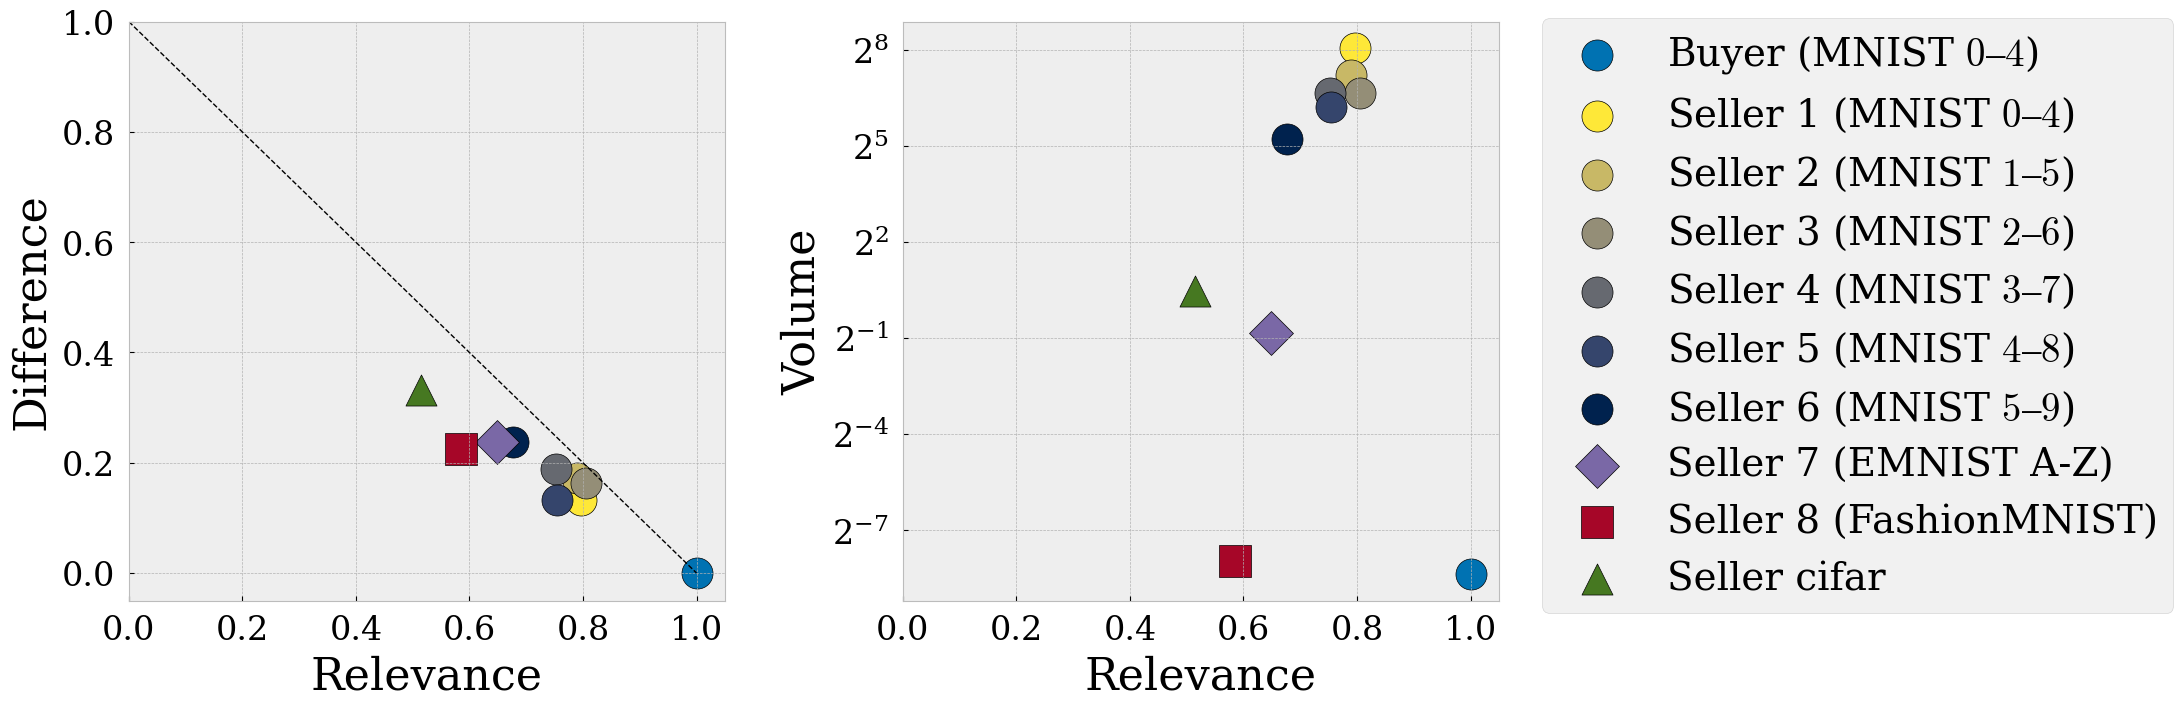

In [46]:
cividis = [np.array([matplotlib.colormaps['cividis'].colors[int(k)]]) for k in np.linspace(255, 0, 6)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(16, 8), ncols=2)

ax[0].scatter(buyer_values['relevance'], buyer_values['diversity'], c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')
ax[0].scatter(seller_1_values['relevance'], seller_1_values['diversity'], c=cividis[0], edgecolor='k', s=s, label=r'Seller mnist $0–4$')
ax[0].scatter(seller_2_values['relevance'], seller_2_values['diversity'], c=cividis[1], edgecolor='k', s=s, label=r'Seller mnist $1–5$')
ax[0].scatter(seller_3_values['relevance'], seller_3_values['diversity'], c=cividis[2], edgecolor='k', s=s, label=r'Seller mnist $2–6$')
ax[0].scatter(seller_4_values['relevance'], seller_4_values['diversity'], c=cividis[3], edgecolor='k', s=s, label=r'Seller mnist $3–7$')
ax[0].scatter(seller_5_values['relevance'], seller_5_values['diversity'], c=cividis[4], edgecolor='k', s=s, label=r'Seller mnist $4–8$')
ax[0].scatter(seller_6_values['relevance'], seller_6_values['diversity'], c=cividis[5], edgecolor='k', s=s, label=r'Seller mnist $5–9$')
ax[0].scatter(emnist_values['relevance'], emnist_values['diversity'], c='C2', edgecolor='k', s=s, marker='D', label=r'Seller emnist')
ax[0].scatter(fashion_values['relevance'], fashion_values['diversity'], c='C1', edgecolor='k', s=s, marker='s', label=r'Seller fashion')
ax[0].scatter(cifar_values['relevance'], cifar_values['diversity'], c='C3', edgecolor='k', s=s, marker='^', label=r'Seller cifar')

ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(-0.05, 1)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(buyer_values['relevance'], buyer_values['volume'],   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(seller_1_values['relevance'], seller_1_values['volume'], c=cividis[0], edgecolor='k', s=s, label=r'Seller 1 (MNIST $0–4$)')
ax[1].scatter(seller_2_values['relevance'], seller_2_values['volume'], c=cividis[1], edgecolor='k', s=s, label=r'Seller 2 (MNIST $1–5$)')
ax[1].scatter(seller_3_values['relevance'], seller_3_values['volume'], c=cividis[2], edgecolor='k', s=s, label=r'Seller 3 (MNIST $2–6$)')
ax[1].scatter(seller_4_values['relevance'], seller_4_values['volume'], c=cividis[3], edgecolor='k', s=s, label=r'Seller 4 (MNIST $3–7$)')
ax[1].scatter(seller_5_values['relevance'], seller_5_values['volume'], c=cividis[4], edgecolor='k', s=s, label=r'Seller 5 (MNIST $4–8$)')
ax[1].scatter(seller_6_values['relevance'], seller_6_values['volume'], c=cividis[5], edgecolor='k', s=s, label=r'Seller 6 (MNIST $5–9$)')
ax[1].scatter(emnist_values['relevance'], emnist_values['volume'],  c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 7 (EMNIST A-Z)')
ax[1].scatter(fashion_values['relevance'], fashion_values['volume'],  c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 8 (FashionMNIST)')
ax[1].scatter(cifar_values['relevance'], cifar_values['volume'], c='C3', edgecolor='k', s=s, marker='^', label=r'Seller cifar')

ax[1].set_xlim(0, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-4}, bbox_to_anchor=(1.04, 1.04))
plt.savefig(figures / f'mnist-compare-diversity-clip-overlap-n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have increasing number of unique classes

/tmp/ipykernel_1472333/4280776607.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/4280776607.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/4280776607.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/4280776607.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


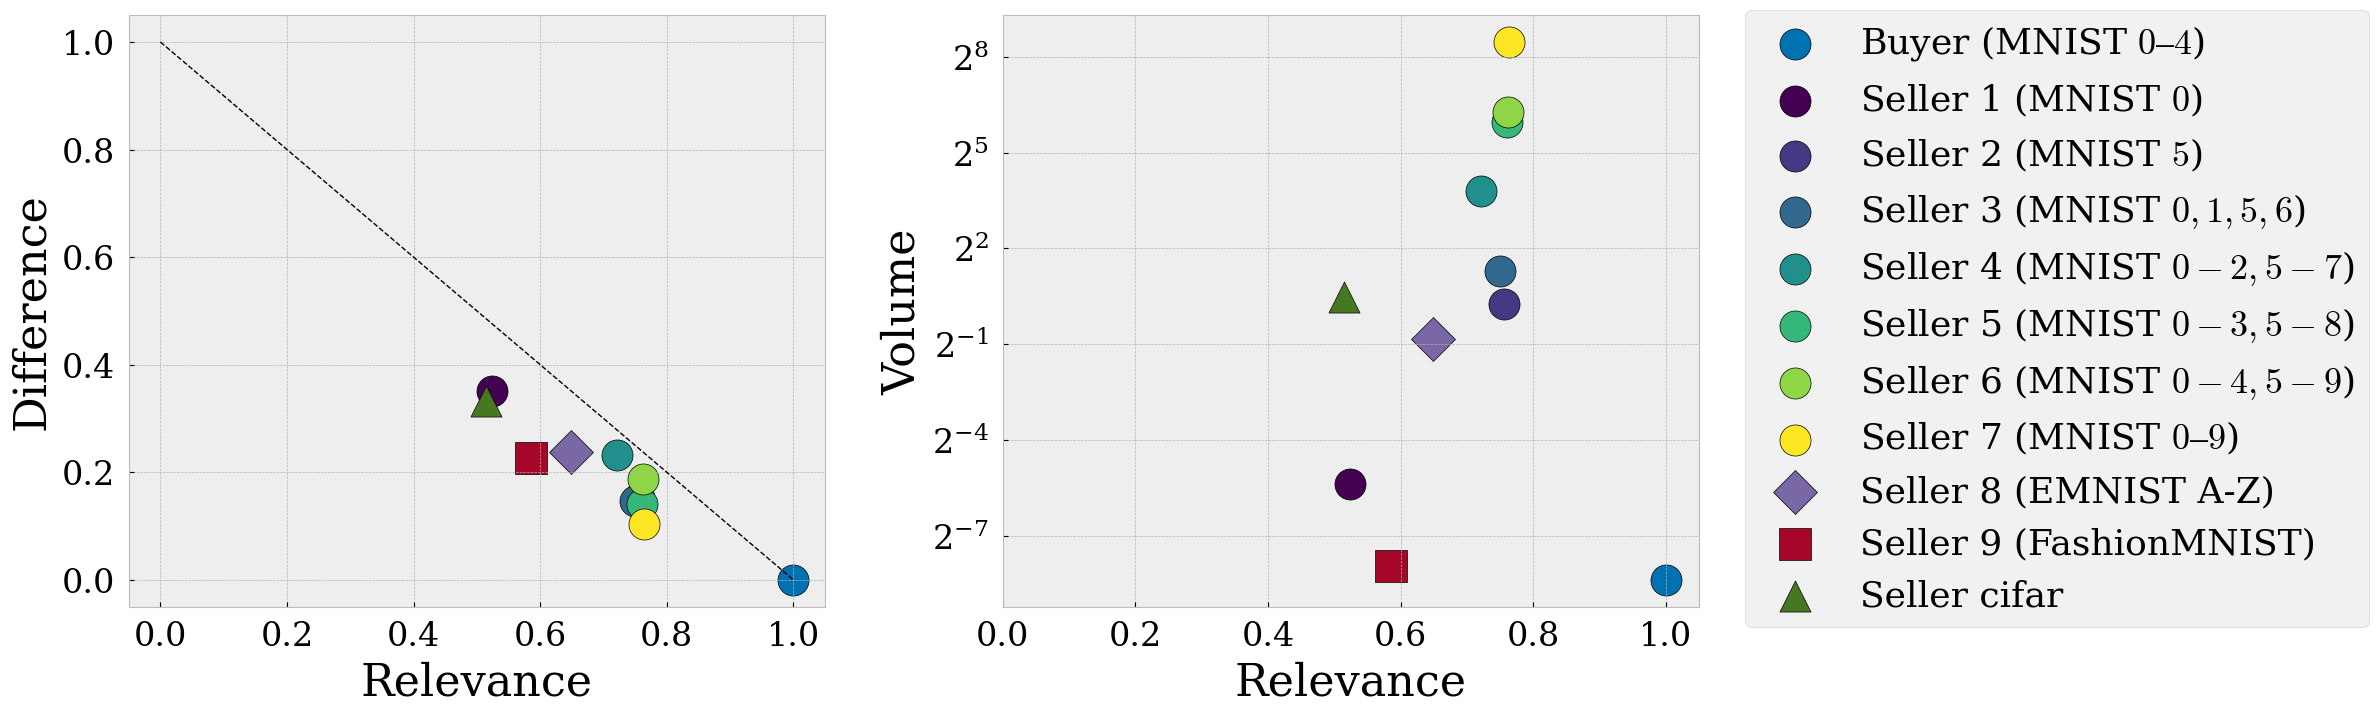

In [47]:
viridis = [np.array([matplotlib.colormaps['viridis'].colors[int(k)]]) for k in np.linspace(0, 255, 7)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(18, 8), ncols=2)

ax[0].scatter(buyer_values['relevance'], buyer_values['diversity'],   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')
ax[0].scatter(seller_7_values['relevance'], seller_7_values['diversity'], c=viridis[0], edgecolor='k', s=s)
ax[0].scatter(seller_8_values['relevance'], seller_8_values['diversity'], c=viridis[1], edgecolor='k', s=s)
ax[0].scatter(seller_9_values['relevance'], seller_9_values['diversity'], c=viridis[2], edgecolor='k', s=s)
ax[0].scatter(seller_10_values['relevance'], seller_10_values['diversity'], c=viridis[3], edgecolor='k', s=s)
ax[0].scatter(seller_11_values['relevance'], seller_11_values['diversity'], c=viridis[4], edgecolor='k', s=s)
ax[0].scatter(seller_12_values['relevance'], seller_12_values['diversity'], c=viridis[5], edgecolor='k', s=s)
ax[0].scatter(seller_13_values['relevance'], seller_13_values['diversity'], c=viridis[6], edgecolor='k', s=s)
ax[0].scatter(emnist_values['relevance'], emnist_values['diversity'], c='C2', edgecolor='k', s=s, marker='D')
ax[0].scatter(fashion_values['relevance'], fashion_values['diversity'], c='C1', edgecolor='k', s=s, marker='s')
ax[0].scatter(cifar_values['relevance'], cifar_values['diversity'], c='C3', edgecolor='k', s=s, marker='^')

# ax[0].set_xlim(0.5, 1.05)
# ax[0].set_ylim(-0.02, 0.5)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(buyer_values['relevance'], buyer_values['volume'],      c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(seller_7_values['relevance'], seller_7_values['volume'],  c=viridis[0], edgecolor='k', s=s, label=r'Seller 1 (MNIST $0$)')
ax[1].scatter(seller_8_values['relevance'], seller_8_values['volume'],  c=viridis[1], edgecolor='k', s=s, label=r'Seller 2 (MNIST $5$)')
ax[1].scatter(seller_9_values['relevance'], seller_9_values['volume'],  c=viridis[2], edgecolor='k', s=s, label=r'Seller 3 (MNIST $0, 1, 5, 6$)')
ax[1].scatter(seller_10_values['relevance'], seller_10_values['volume'],  c=viridis[3], edgecolor='k', s=s, label=r'Seller 4 (MNIST $0-2, 5-7$)')
ax[1].scatter(seller_11_values['relevance'], seller_11_values['volume'],  c=viridis[4], edgecolor='k', s=s, label=r'Seller 5 (MNIST $0-3, 5-8$)')
ax[1].scatter(seller_12_values['relevance'], seller_12_values['volume'],  c=viridis[5], edgecolor='k', s=s, label=r'Seller 6 (MNIST $0-4, 5-9$)')
ax[1].scatter(seller_13_values['relevance'], seller_13_values['volume'],  c=viridis[6], edgecolor='k', s=s, label=r'Seller 7 (MNIST $0–9$)')
ax[1].scatter(emnist_values['relevance'], emnist_values['volume'],  c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 8 (EMNIST A-Z)')
ax[1].scatter(fashion_values['relevance'], fashion_values['volume'],  c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 9 (FashionMNIST)')
ax[1].scatter(cifar_values['relevance'], cifar_values['volume'],  c='C3', edgecolor='k', s=s, marker='^', label=r'Seller cifar')

ax[1].set_xlim(0.0, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-6}, bbox_to_anchor=(1.04, 1.04))
plt.savefig(figures / f'mnist-compare-diversity-clip-classes-n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have increasing amount of duplicated data

/tmp/ipykernel_1472333/3123102502.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/3123102502.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/3123102502.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/3123102502.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


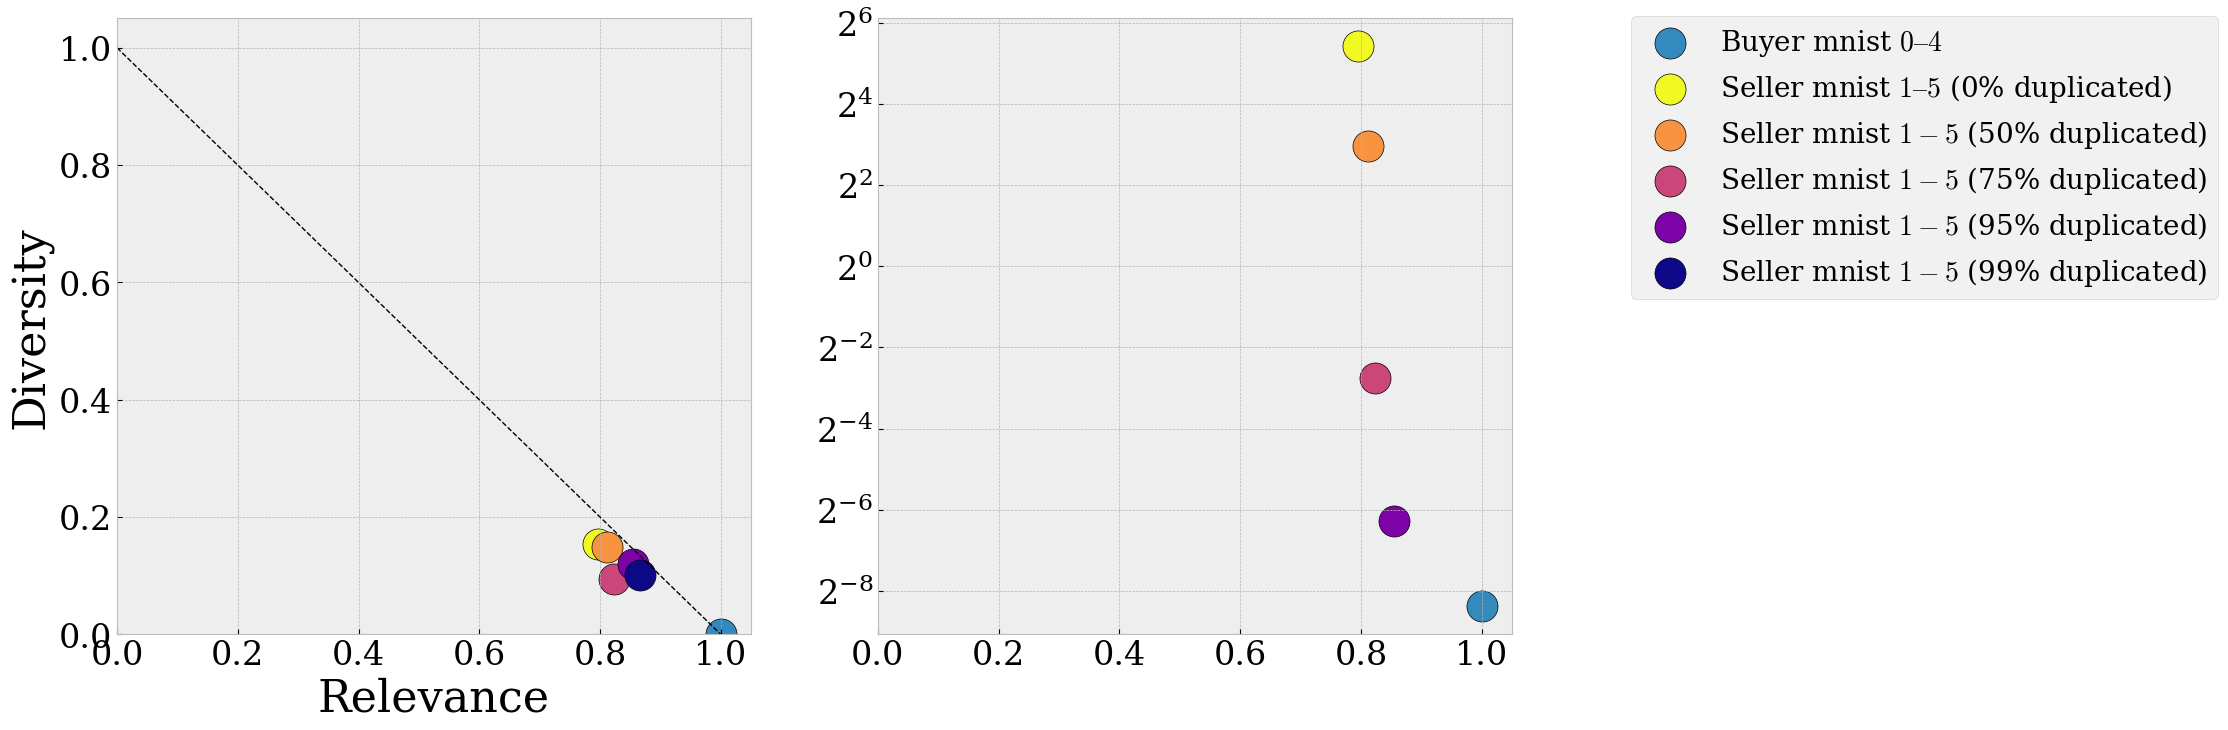

In [48]:
plasma = np.array([matplotlib.colormaps['plasma'].colors[int(k)] for k in np.linspace(255, 0, 5)])[:, None]

s = 500
fig, ax = plt.subplots(figsize=(18, 8), ncols=2)

ax[0].scatter(buyer_values['relevance'], buyer_values['diversity'],  edgecolor='k', s=s, label=r'Buyer mnist $0–4$')
ax[0].scatter(dup_1_values['relevance'], dup_1_values['diversity'], c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1–5$ (0% duplicated)')
ax[0].scatter(dup_2_values['relevance'], dup_2_values['diversity'], c=plasma[1], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (50% duplicated)')
ax[0].scatter(dup_3_values['relevance'], dup_3_values['diversity'], c=plasma[2], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (75% duplicated)')
ax[0].scatter(dup_4_values['relevance'], dup_4_values['diversity'], c=plasma[3], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (95% duplicated)')
ax[0].scatter(dup_5_values['relevance'], dup_5_values['diversity'], c=plasma[4], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (99% duplicated)')
ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(0, 1.05)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=32)
ax[0].set_ylabel('Diversity', fontsize=32)

ax[1].scatter(buyer_values['relevance'], buyer_values['volume'],   edgecolor='k', s=s)
ax[1].scatter(dup_1_values['relevance'], dup_1_values['volume'], c=plasma[0], edgecolor='k', s=s)
ax[1].scatter(dup_2_values['relevance'], dup_2_values['volume'], c=plasma[1], edgecolor='k', s=s)
ax[1].scatter(dup_3_values['relevance'], dup_3_values['volume'], c=plasma[2], edgecolor='k', s=s)
ax[1].scatter(dup_4_values['relevance'], dup_4_values['volume'], c=plasma[3], edgecolor='k', s=s)
ax[1].scatter(dup_5_values['relevance'], dup_5_values['volume'], c=plasma[4], edgecolor='k', s=s)
ax[1].set_xlim(0, 1.05)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log', base=2)
fig.legend(prop={'size': 20}, bbox_to_anchor=(1.30, 0.90))
plt.savefig(figures / f'mnist-compare-diversity-clip-duplication-n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have mixed MNIST / FashionMNIST data

/tmp/ipykernel_1472333/3138820871.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/3138820871.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/3138820871.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_1472333/3138820871.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


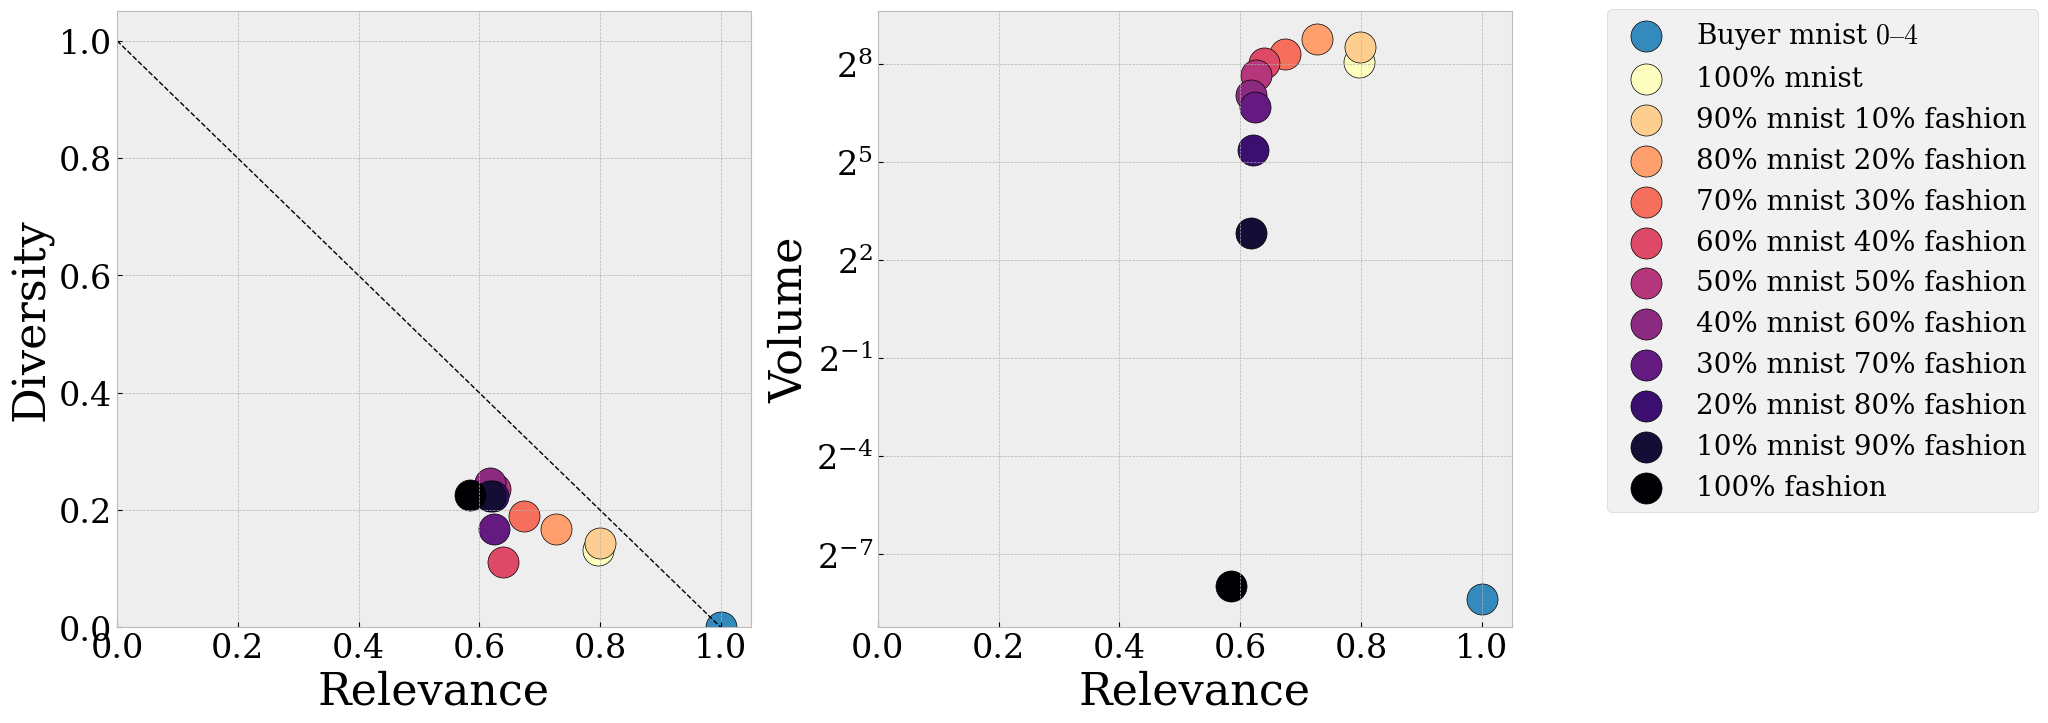

In [49]:
magma = [[matplotlib.colormaps['magma'].colors[int(k)]] for k in np.linspace(255, 0, 11)]


s = 500
fig, ax = plt.subplots(figsize=(18, 8), ncols=2)

ax[0].scatter(buyer_values['relevance'], buyer_values['diversity'],   c='C0', edgecolor='k', s=s, label=r'Buyer mnist $0–4$')
ax[0].scatter(seller_1_values['relevance'], seller_1_values['diversity'], c=magma[0], edgecolor='k', s=s, label=r'100% mnist')
ax[0].scatter(mix_1_values['relevance'], mix_1_values['diversity'], c=magma[1], edgecolor='k', s=s, label=r'90% mnist 10% fashion')
ax[0].scatter(mix_2_values['relevance'], mix_2_values['diversity'], c=magma[2], edgecolor='k', s=s, label=r'80% mnist 20% fashion')
ax[0].scatter(mix_3_values['relevance'], mix_3_values['diversity'], c=magma[3], edgecolor='k', s=s, label=r'70% mnist 30% fashion')
ax[0].scatter(mix_4_values['relevance'], mix_4_values['diversity'], c=magma[4], edgecolor='k', s=s, label=r'60% mnist 40% fashion')
ax[0].scatter(mix_5_values['relevance'], mix_5_values['diversity'], c=magma[5], edgecolor='k', s=s, label=r'50% mnist 50% fashion')
ax[0].scatter(mix_6_values['relevance'], mix_6_values['diversity'], c=magma[6], edgecolor='k', s=s, label=r'40% mnist 60% fashion')
ax[0].scatter(mix_7_values['relevance'], mix_7_values['diversity'], c=magma[7], edgecolor='k', s=s, label=r'30% mnist 70% fashion')
ax[0].scatter(mix_8_values['relevance'], mix_8_values['diversity'], c=magma[8], edgecolor='k', s=s, label=r'20% mnist 80% fashion')
ax[0].scatter(mix_9_values['relevance'], mix_9_values['diversity'], c=magma[9], edgecolor='k', s=s, label=r'10% mnist 90% fashion')
ax[0].scatter(fashion_values['relevance'], fashion_values['diversity'], c=magma[10], edgecolor='k', s=s, label=r'100% fashion')
ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(0, 1.05)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=32)
ax[0].set_ylabel('Diversity', fontsize=32)

ax[1].scatter(buyer_values['relevance'], buyer_values['volume'],  c='C0', edgecolor='k', s=s)
ax[1].scatter(seller_1_values['relevance'], seller_1_values['volume'], c=magma[0], edgecolor='k', s=s)
ax[1].scatter(mix_1_values['relevance'], mix_1_values['volume'], c=magma[1], edgecolor='k', s=s)
ax[1].scatter(mix_2_values['relevance'], mix_2_values['volume'], c=magma[2], edgecolor='k', s=s)
ax[1].scatter(mix_3_values['relevance'], mix_3_values['volume'], c=magma[3], edgecolor='k', s=s)
ax[1].scatter(mix_4_values['relevance'], mix_4_values['volume'], c=magma[4], edgecolor='k', s=s)
ax[1].scatter(mix_5_values['relevance'], mix_5_values['volume'], c=magma[5], edgecolor='k', s=s)
ax[1].scatter(mix_6_values['relevance'], mix_6_values['volume'], c=magma[6], edgecolor='k', s=s)
ax[1].scatter(mix_7_values['relevance'], mix_7_values['volume'], c=magma[7], edgecolor='k', s=s)
ax[1].scatter(mix_8_values['relevance'], mix_8_values['volume'], c=magma[8], edgecolor='k', s=s)
ax[1].scatter(mix_9_values['relevance'], mix_9_values['volume'], c=magma[9], edgecolor='k', s=s)
ax[1].scatter(fashion_values['relevance'], fashion_values['volume'], c=magma[10], edgecolor='k', s=s)
ax[1].set_xlim(0, 1.05)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].set_xlabel('Relevance', fontsize=32)
ax[1].set_ylabel('Volume', fontsize=32)
fig.legend(prop={'size': 20}, bbox_to_anchor=(1.20, 0.90))
plt.savefig(figures / f'mnist-compare-diversity-clip-mixed-n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()
